<a href="https://colab.research.google.com/github/pena-rodrigo/golombCA1/blob/main/param_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sbi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
from scipy import stats as spstats
from scipy.signal import find_peaks
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

import pylab
pylab.rcParams['savefig.dpi'] = 120

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

import pickle

In [3]:
#@title Mount drive
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/param_estim'

dataload = np.loadtxt(f"{images_dir}/v_trials.dat")  

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#@title HHca2
class HHca2:
    """Golomb model with Ca + second compartment with I_h"""
    nid=0 #default neuron id
    sendspk=0
    
    C = 1.
    Gl=0.05
    Vl = -70.
    Gna = 35.
    Gnap = 0.3 #varies between 0 and 0.41 mS/cm2
    thetam = -30.
    deltam = 9.5
    Vna = 55.
    Gkdr = 6.
    thetah = -45.
    deltah = -7.
    thetaht= -40.5
    deltaht= -6.
    Vk = -90.
    thetap = -41. #-47#-41 #varies between -47mV and -41mV
    deltap = 3.
    thetan = -35.
    deltan = 10.
    thetant =-27.
    deltant=-15.
    Ga = 1.4
    thetaa = -50.
    deltaa = 20.
    taub = 15.
    thetab = -80.
    deltab = -6.
    Gm = 1.
    tauz = 75.
    thetaz = -39.
    deltaz = 5.
    
    Gca = 0.2#0.#0*0.2 #varies between 0 and 0.2 mS/cm2
    Gc = 10.
    Gsahp = 5.
    Vca = 120.
    thetar=-20.
    deltar=10.
    taur=1.
    thetac=-30.
    deltac=7.
    tauc=2.
    ac=6.
    tauq=450.
    aq=2.
    
    nu=0.13
    tauca=13.
    
    Iapp = 0.9
    Inoise=0.0

    """second compartment parameters"""
    Gl2 = Gl
    Gh2 = 2.
    Vh2 = -32.9
    Iapp2 = 0.9

    """couplings between compartments"""
    Gsd = 0.2
    Gds = 0.2
    
    D = 0.0   
    Dz = .5e-5
    
    Ein=-80.
    Eex=0.
    Gie=0.08
    Goe=5*0.08#0.15
    tauR_ampa = 0.1
    tauD_ampa = 3.0
    tauR_gaba = 0.2
    tauD_gaba = 20.

    vth= 0#-20
    Iin = 0
    Iin2 = 0

    countdelay=0
    countdelay2=0
    
    spktimes = []

    gext = 8. #ext
    tauext=10. #ext

    gextdend = 8. #ext
    tauextdend=10. #ext

    
    def __init__(self,nid=1,D=0.1,Gna = 35,Gnap=0.3,Gl=0.05,Gl2=0.05,Gkdr=6,Ca_acum=0.0001,Gca=0.2, Iapp=0.9, No = 1.0, Ni=1.0, Dz=.5e-5, Gc = 10., Gsahp= 5., Iapp2=Iapp2, Gm = 1., Ga = 1.4, Gh2=2.0):
        self.Gie = self.Gie/Ni
        self.Goe = self.Goe/No
        self.minf= lambda V:  1.0/(1+np.exp(-(V-self.thetam)/self.deltam))
        self.hinf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetah)/self.deltah)),0,1)
        self.tauh= lambda V:  0.1 + 0.75*(1.0/(1+np.exp(-(V-self.thetaht)/self.deltaht)))
        self.ninf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetan)/self.deltan)),0,1)
        self.taun= lambda V:  0.1 + 0.5*(1.0/(1+np.exp(-(V-self.thetant)/self.deltant)))
        self.pinf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetap)/self.deltap)),0,1)
        self.ainf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetaa)/self.deltaa)),0,1)
        self.binf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetab)/self.deltab)),0,1)
        self.zinf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetaz)/self.deltaz)),0,1)
        
        self.rinf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetar)/self.deltar)),0,1)
        self.cinf= lambda V:  np.clip(1.0/(1+np.exp(-(V-self.thetac)/self.deltac)),0,1)
        self.dinf= lambda Ca_acum:  np.clip(1.0/(1+self.ac/Ca_acum),0,1)
        self.qinf= lambda Ca_acum:  np.clip(1.0/(1+(self.aq**4)/(Ca_acum**4)),0,1)

        """for h-current of dendrite"""
        self.h2_inf = lambda V: np.clip(1./(1. + np.exp((V + 84.)/10.2)),0,1)
        self.tauh2 = lambda V: 1./(np.exp(-17.9 - 0.116*V ) + np.exp(-1.84 + 0.09*V )) + 0.1

        self.Nv = lambda V: ( 1+np.tanh((V)/4.0) )#/2.
        self.Nv2 = lambda V: ( 1+np.tanh((V)/4.0) )#/2.
        
        self.nid = nid
        
        self.D = D      
        self.v = -72.#-89.09
        self.h = 0
        self.n = 0
        self.b = 0
        self.z = 0       
        self.s = 0
        self.sie=0
        self.soe=0
        self.r=0
        self.c=0
        self.Ca_acum= Ca_acum #
        
        ###to infer
        self.Dz = Dz
        self.Gna= Gna
        self.Gnap= Gnap
        self.Gl= Gl ##
        self.Gkdr= Gkdr ##
        self.Gca = Gca
        self.Iapp=Iapp
        self.Iapp2=Iapp2
        self.Gc = Gc
        self.Gsahp = Gsahp
        self.Gm = Gm
        self.Ga = Ga
        self.Gh2 = Gh2
        self.Gl2 = Gl2
        
        self.q=0

        self.sext = 0 #external current
        self.sextdend = 0
        
        """second compartment variables"""
        self.v2 = -72.
        self.h2 = 0
        self.s2 = 0
        
        self.spktimes = []
        
    def _UpdateKs(self,v,h,n,b,z,r,c,Ca_acum,q,s,v2,h2,s2,sext,sextdend, stim, stim2):
        Isyn = self.Gie*self.sie*(v-self.Ein)
        self.Iin = Isyn

        Isyn2 = self.Gie*self.soe*(v2-self.Ein)
        self.Iin2 = Isyn2

        Iext = self.gext*sext * (v-self.Ein) #added to the soma
        Iextdend = self.gextdend*sextdend * (v-self.Ein) #added to the dendrite
        """Ext inputs"""
        ksext = -sext/self.tauext
        ksextdend = -sextdend/self.tauextdend
        
        """somatic currents"""
        Il = self.Gl * (v - self.Vl)
        Ina  = self.Gna * (self.minf(v)**3) * h *(v-self.Vna)
        Inap = self.Gnap * self.pinf(v) * (v-self.Vna)
        Ikdr = self.Gkdr * (n**4) * (v-self.Vk) 
        IA   = self.Ga * (self.ainf(v)**3) * b * (v-self.Vk)
        IM   = self.Gm * z * (v-self.Vk)
        
        Ica  = self.Gca * (r**2) * (v-self.Vca) 
        Ic   = self.Gc * self.dinf(Ca_acum) * c * (v-self.Vk)
        Isahp= self.Gsahp * q * (v-self.Vk)

        """conection between v and v2"""
        Isd = self.Gsd*(v2-v)
        Ids = self.Gds*(v-v2)

        """h-current term for v2"""
        Il2 = self.Gl2 * (v2- self.Vl)
        Ih2 = self.Gh2 * h2 * (v2- self.Vh2)
        
        Itotal =  self.Iapp - Il - Ina - Inap - Ikdr - IA - IM - Ica - Ic - Isahp - Isyn + Isd  + stim - Iext
        Itotal2 = self.Iapp2 - Il2 - Ih2 - Isyn2 + Ids + stim2 - Iextdend

        kv = Itotal / (self.C)
        kh = (self.hinf(v)-h)/self.tauh(v)
        kn = (self.ninf(v)-n)/self.taun(v)
        kb = (self.binf(v)-b)/self.taub
        kz = (self.zinf(v)-z)/self.tauz     
        
        kr = (self.rinf(v)-r)/self.taur  
        kc = (self.cinf(v)-c)/self.tauc
        kCa_acum = -self.nu*Ica - Ca_acum/self.tauca
        kq = (self.qinf(Ca_acum)-q)/self.tauq
        
        ks = self.Nv(v)*(1-s)/self.tauR_ampa - s/self.tauD_ampa
        ks2 = self.Nv2(v2)*(1-s2)/self.tauR_ampa - s2/self.tauD_ampa

        """v2 compartment"""
        kv2 = Itotal2 / (self.C)
        kh2 = (self.h2_inf(v2)-h2)/self.tauh2(v2)

        return kv, kh, kn, kb, kz, kr, kc, kCa_acum, kq, ks, kv2, kh2, ks2, ksext, ksextdend

    def _Updatev(self,stim,stim2,sie,soe,dt,time):
        self.sie = sie
        self.soe = soe
  
        k1v, k1h, k1n, k1b, k1z, k1r, k1c, k1Ca_acum, k1q, k1s, k1v2, k1h2, k1s2, k1sext, k1sextdend = self._UpdateKs(self.v,self.h,self.n,self.b,self.z,self.r,self.c,self.Ca_acum,self.q,self.s,self.v2,self.h2,self.s2,self.sext,self.sextdend,stim,stim2)
        a_v= self.v + k1v*dt/2
        a_h= self.h + k1h*dt/2
        a_n= self.n + k1n*dt/2
        a_b= self.b + k1b*dt/2
        a_z= self.z + k1z*dt/2
        a_r= self.r + k1r*dt/2
        a_c= self.c + k1c*dt/2
        a_Ca_acum= self.Ca_acum + k1Ca_acum*dt/2
        a_q= self.q + k1q*dt/2
        a_s= self.s + k1s*dt/2
        a_v2 = self.v2 + k1v2*dt/2
        a_h2 = self.h2 + k1h2*dt/2
        a_s2 = self.s2 + k1s2*dt/2
        a_sext= self.sext + k1sext*dt/2
        a_sextdend= self.sextdend + k1sextdend*dt/2

        k2v, k2h, k2n, k2b, k2z, k2r, k2c, k2Ca_acum, k2q, k2s, k2v2, k2h2, k2s2, k2sext, k2sextdend = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,a_v2,a_h2,a_s2,a_sext,a_sextdend,stim,stim2)
        a_v= self.v + k2v*dt/2
        a_h= self.h + k2h*dt/2
        a_n= self.n + k2n*dt/2
        a_b= self.b + k2b*dt/2
        a_z= self.z + k2z*dt/2
        a_r= self.r + k2r*dt/2
        a_c= self.c + k2c*dt/2
        a_Ca_acum= self.Ca_acum + k2Ca_acum*dt/2
        a_q= self.q + k2q*dt/2
        a_s= self.s + k2s*dt/2
        a_v2 = self.v2 + k2v2*dt/2
        a_h2 = self.h2 + k2h2*dt/2
        a_s2 = self.s2 + k2s2*dt/2
        a_sext= self.sext + k2sext*dt/2
        a_sextdend= self.sextdend + k2sextdend*dt/2

        k3v, k3h, k3n, k3b, k3z, k3r, k3c, k3Ca_acum, k3q, k3s, k3v2, k3h2, k3s2, k3sext, k3sextdend = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,a_v2,a_h2,a_s2,a_sext,a_sextdend,stim,stim2)
        a_v= self.v + k3v*dt
        a_h= self.h + k3h*dt
        a_n= self.n + k3n*dt
        a_b= self.b + k3b*dt
        a_z= self.z + k3z*dt
        a_r= self.r + k3r*dt
        a_c= self.c + k3c*dt
        a_Ca_acum= self.Ca_acum + k3Ca_acum*dt
        a_q= self.q + k3q*dt
        a_s= self.s + k3s*dt
        a_v2 = self.v2 + k3v2*dt
        a_h2 = self.h2 + k3h2*dt
        a_s2 = self.s2 + k3s2*dt
        a_sext= self.sext + k3sext*dt
        a_sextdend= self.sextdend + k3sextdend*dt

        k4v, k4h, k4n, k4b, k4z, k4r, k4c, k4Ca_acum, k4q, k4s, k4v2, k4h2, k4s2, k4sext, k4sextdend = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,a_v2,a_h2,a_s2,a_sext,a_sextdend,stim,stim2)
        self.Inoise = np.random.randn()*np.sqrt(2*self.D*dt)
        self.v += dt*(k1v+2*k2v+2*k3v+k4v)/6 + self.Inoise
        self.h += dt*(k1h+2*k2h+2*k3h+k4h)/6
        self.n += dt*(k1n+2*k2n+2*k3n+k4n)/6
        self.b += dt*(k1b+2*k2b+2*k3b+k4b)/6
        self.z += dt*(k1z+2*k2z+2*k3z+k4z)/6 + np.random.randn()*np.sqrt(2*self.Dz*dt)
        if self.z<0:
         self.z = 0
        self.r += dt*(k1r+2*k2r+2*k3r+k4r)/6
        self.c += dt*(k1c+2*k2c+2*k3c+k4c)/6
        self.Ca_acum += dt*(k1Ca_acum+2*k2Ca_acum+2*k3Ca_acum+k4Ca_acum)/6
        self.q += dt*(k1q+2*k2q+2*k3q+k4q)/6
        self.s += dt*(k1s+2*k2s+2*k3s+k4s)/6
        self.v2 += dt*(k1v2+2*k2v2+2*k3v2+k4v2)/6
        self.h2 += dt*(k1h2+2*k2h2+2*k3h2+k4h2)/6
        self.s2 += dt*(k1s2+2*k2s2+2*k3s2+k4s2)/6
        self.sext += dt*(k1sext+2*k2sext+2*k3sext+k4sext)/6
        self.sextdend += dt*(k1sextdend+2*k2sextdend+2*k3sextdend+k4sextdend)/6

        self.sendspk=0
        if(self.v>self.vth):
            self.spktimes.append(time)
            self.sendspk=1
        
    def add_external(self):
       self.sext += 1

    def add_externaldend(self):
       self.sextdend += 1
        
    def eval(self,stim,stim2,sie,soe,dt,time):
        self._Updatev(stim,stim2,sie,soe,dt,time)

In [5]:
FS=828; dt_record = 1000/FS; #ms
A_soma = np.pi * ((70.0 * 1e-4) ** 2) ## cm2
dt=0.1
Izap = lambda i, Fzap, A: A*np.sin(2*np.pi*Fzap*10**-3*i*dt + 3*np.pi/2)

def HHsimulatorGolomb(V0, params, dt, t, I, seed=None):  
    
    gbar_Nap = params[0, 0]  
    gbar_Kdr = params[0, 1]  
    gbar_l = params[0, 2]  
    gbar_c = params[0, 3]
    gbar_ca = params[0, 4] 
    gbar_a = params[0,5]
    gbar_sahp = params[0,6]
    gbar_m = params[0,7]
    gbar_gh2 = params[0,8]
    gbar_gl2 = params[0,9]


    iapp2=params[0,10]
    iapp=params[0,11]
    nois_fact = params[0, 12]    
    Dz=params[0,13]
 
    Amp1=params[0, 14] #0.5
    Amp2=params[0, 15]
    Amp3=params[0, 16]
    Amp4=params[0, 17]

    Neu = HHca2(Gnap = gbar_Nap , Gkdr = gbar_Kdr, Iapp=iapp,Dz=Dz,Gca=gbar_ca,D=nois_fact,Iapp2=iapp2,Gl = gbar_l,Gc=gbar_c,Gsahp=gbar_sahp, Gm=gbar_m, Ga=gbar_a, Gh2=gbar_gh2, Gl2=gbar_gl2)
    V = np.zeros_like(t)

    for i in range(1, t.shape[0]):
        Itheta1 = Izap(i,8,Amp1)
        Igamma1 = Izap(i,43,Amp2)
        Itheta2 = Izap(i,8,Amp3)
        Igamma2 = Izap(i,43,Amp4)

        Neu.eval(Igamma2+Itheta2,Igamma1+Itheta1+1,0,0,dt, i*dt)   
        V[i] = Neu.v
    return np.array(V).reshape(-1, 1)  

def calculate_summary_statistics(x,time=None):
    """Calculate summary statistics
    Parameters
    ----------
    x : output of the simulator
    Returns
    -------
    np.array, summary statistics
    """
    dt = x["dt"]
    t_on=0
    t_off=1000
    duration=1000
    curr_level=5e-4
    t = np.arange(0, duration + dt, dt)
    I = np.zeros_like(t)
    I[int(np.round(t_on / dt)) : int(np.round(t_off / dt))] = (
        curr_level / A_soma
    ) 

    n_mom = 9
    n_summary = 12

    n_summary = np.minimum(n_summary, n_mom + 3)

    if(time is not None):
      t = time

    SSNe = list([])
    CSNe = list([])
    dist = 14.0   #distance to distinguish ss/cs
    Ne=1
    for k in range(Ne):
      vs = np.array(x["data"])
      ids, _ = find_peaks(vs>-20) #find the indices of spike
      """searching the CB"""
      sb = []
      for i in range(1,len(ids)):   #backward searching
        if t[ids[i]]-t[ids[i-1]]<dist:
          sb.append(ids[i])
      for i in range(len(ids)-1):   #foward searching
        if t[ids[i+1]]-t[ids[i]]<dist:
          sb.append(ids[i])
      sb = np.sort(sb)              #order
      sb = np.unique(sb)            #... and remove duplicate values   
      """find the SS"""
      ss = ids
      for i in sb:
        ind = np.where(ss == i)
        ss = np.delete(ss,ind)
      """save the SS and CS"""
      SSNe.append(ss)
      CSNe.append(sb)

    # resting potential and std
    rest_pot = np.mean(x["data"])
    rest_pot_std = np.std(x["data"])

    # moments
    std_pw = np.power(
        np.std(x["data"]), np.linspace(3, n_mom, n_mom - 2) 
    )
    std_pw = np.concatenate((np.ones(1), std_pw))
    moments = (
        spstats.moment(
            x["data"], np.linspace(2, n_mom, n_mom - 1) 
        )
        / std_pw
    )
    isi=np.diff(find_peaks(x['data']>-20)[0])
    cv=np.std(isi)/np.mean(isi)

    isi_SSNe=np.diff(SSNe[0])
    cv_SSNe=np.std(isi_SSNe)/np.mean(isi_SSNe)

    isi_CSNe=np.diff(CSNe[0])
    cv_CSNe=np.std(isi_CSNe)/np.mean(isi_CSNe)

    # concatenation of summary statistics
    sum_stats_vec = np.concatenate(
        (
            np.array([1000*len(find_peaks(x['data']>-20)[0])/t[-1]]),
            np.array([cv]),
            np.array([1000*len(SSNe[0])/t[-1]]),
            np.array([cv_SSNe]),
            np.array([1000*len(CSNe[0])/t[-1]]),                 
            np.array([cv_CSNe]),
            np.array(
                [rest_pot, rest_pot_std]
            ),
            moments,
        )
    )
    sum_stats_vec = sum_stats_vec[0:n_summary]

    return sum_stats_vec

In [6]:
def run_HH_model(params,Duration=None):
    dt=0.1
    params = np.asarray(params)

    t_on=0
    t_off=1000
    if(Duration is None):
      duration=1000
    else:
      duration=Duration
      toff=duration
    curr_level=5e-4
    t = np.arange(0, duration + dt, dt)
    I = np.zeros_like(t)
    I[int(np.round(t_on / dt)) : int(np.round(t_off / dt))] = (
        curr_level / A_soma
    ) 
    V0 = -70

    states = HHsimulatorGolomb(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

In [7]:
def simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.

    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

In [8]:
prior_min = [0.2, 2.0,  0.01, 5.0,  0.05, 0.1, 5.0, 0.1,  1.0,  0.05, -3.0, -3.0, 0.1,  0.1e-5,  1.0,   1.0,  1.0,  1.0]
prior_max = [2.0, 10.0, 0.09, 15.0, 0.5,  3.0, 15.0, 3.0, 10.0, 0.5,   3.0,  3.0, 10.0, 1.0e-5,  10.0 , 10.0, 10.0, 10.0 ]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

In [9]:
posterior = infer(
    simulation_wrapper, prior, method="SNPE", num_simulations=500, num_workers=8
)

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 104 epochs.

In [10]:
#Save posterior
Output_file = open(f"{images_dir}/PosteriorOutput.obj", 'wb') 
pickle.dump(posterior, Output_file)
Output_file.close()

# Output_file = open(f"{images_dir}/PosteriorOutput.obj", 'rb') 
# unpickledPosterior = pickle.load(Output_file)

In [12]:
curr_level=5e-4
t_on=0
t_off=10000
duration=10000
time = np.arange(10000)*dt_record
I = np.zeros_like(time)
I[int(np.round(t_on / dt_record)) : int(np.round(time[-1] / dt_record))] = (
    curr_level / A_soma
) 
observation_trace = dict(data=dataload[2000:12000,0], time=time, dt=dt_record, I=I)

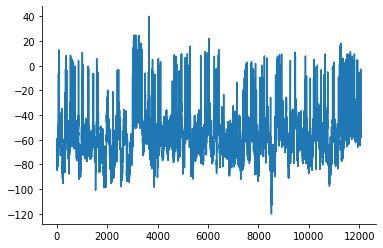

In [13]:
##rescale between [a,b]
a=-80; a=-120; b=40;
observation_trace['data'] = (b-a)*(observation_trace['data']-min(observation_trace['data']))/(max(observation_trace['data'])-min(observation_trace['data'])) + a
plt.plot(time,observation_trace['data'])

In [14]:
observation_summary_statistics = calculate_summary_statistics(observation_trace,time)

In [92]:
## posterior given the observed data
samples = posterior.sample((20000,), x=observation_summary_statistics)

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    19978 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


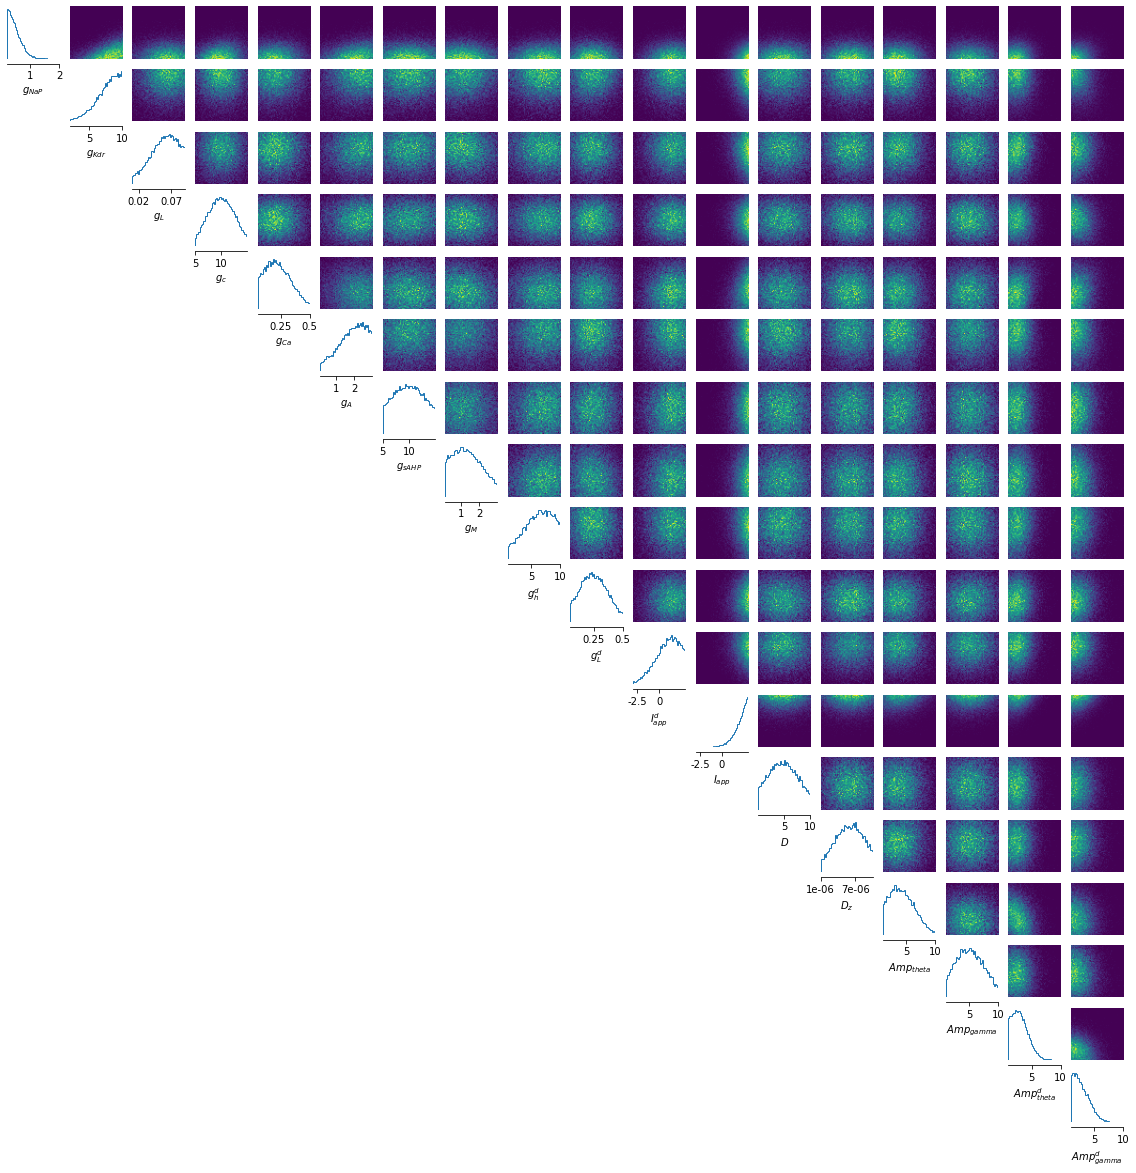

In [94]:
fig, axes = analysis.pairplot(
    samples,
    limits = [[prior_min[0], prior_max[0]], [prior_min[1], prior_max[1]], [prior_min[2], prior_max[2]],[prior_min[3], prior_max[3]], [prior_min[4], prior_max[4]], [prior_min[5], prior_max[5]], [prior_min[6], prior_max[6]],
              [prior_min[7], prior_max[7]], [prior_min[8], prior_max[8]], [prior_min[9], prior_max[9]], [prior_min[10], prior_max[10]], [prior_min[11], prior_max[11]], [prior_min[12], prior_max[12]], [prior_min[13], prior_max[13]],
              [prior_min[14], prior_max[14]], [prior_min[15], prior_max[15]], [prior_min[16], prior_max[16]], [prior_min[17], prior_max[17]]],
    labels = [r"$g_{NaP}$", r"$g_{Kdr}$", r"$g_{L}$", r"$g_{c}$", r"$g_{Ca}$", r"$g_{A}$", r"$g_{sAHP}$", 
                     r"$g_{M}$", r"$g_{h}^d$", r"$g_{L}^d$", r"$I_{app}^d$", r"$I_{app}$", r"$D$", r"$D_z$", r"$Amp_{theta}$", r"$Amp_{gamma}$", r"$Amp_{theta}^d$", r"$Amp_{gamma}^d$"],
    ticks=[[1, 2], [5, 10],[0.02,0.07],[5,10, 15],[0.25,0.5],[1,2,3],[5,10,15],[1,2,3],[5,10],[0.25,0.5],[-2.5,0,2.5],[-2.5,0,2.5],[5,10],[1e-6,7e-6],[5,10],[5,10],[5,10],[5,10]],
    figsize=(20, 20),
    points_offdiag={"markersize": 6},
    points_colors="r",
);

plt.savefig(f"{images_dir}/pairplot.png")
plt.savefig(f"{images_dir}/pairplot.pdf")  

In [61]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), x=observation_summary_statistics).numpy()


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    -26 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


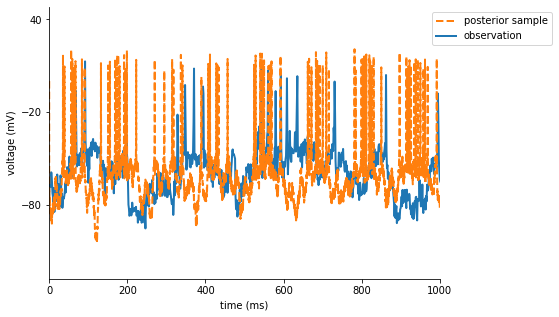

In [62]:
fig = plt.figure(figsize=(7, 5))

# plot observation
# t = observation_trace["time"]
y_obs = observation_trace["data"]
plt.plot(observation_trace["time"], y_obs, lw=2, label="observation")

# simulate and plot samples
x = run_HH_model(posterior_sample,Duration=10000)
dt=0.1
duration=10000
t = np.arange(0, duration + dt, dt)
plt.plot(t,x["data"], "--", lw=2, label="posterior sample")

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

# ax.set_xticks([0, 60, 120])
ax.set_yticks([-80, -20, 40]);
plt.xlim([0,1000])

plt.savefig(f"{images_dir}/single_match.png")
plt.savefig(f"{images_dir}/single_match.pdf")  

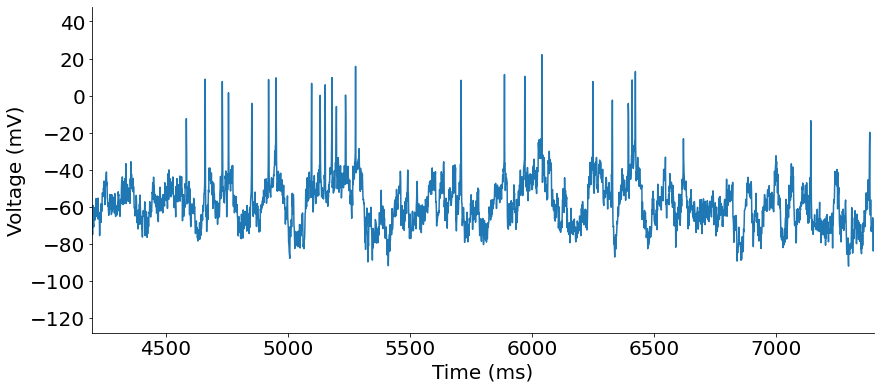

In [91]:
plt.figure(figsize=(14,6))
ax=plt.subplot(111)
plt.plot(observation_trace["time"], y_obs)
plt.xlim([4200,7400])
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(20)

plt.savefig(f"{images_dir}/ss_sb_data.png")
plt.savefig(f"{images_dir}/ss_sb_data.pdf")  

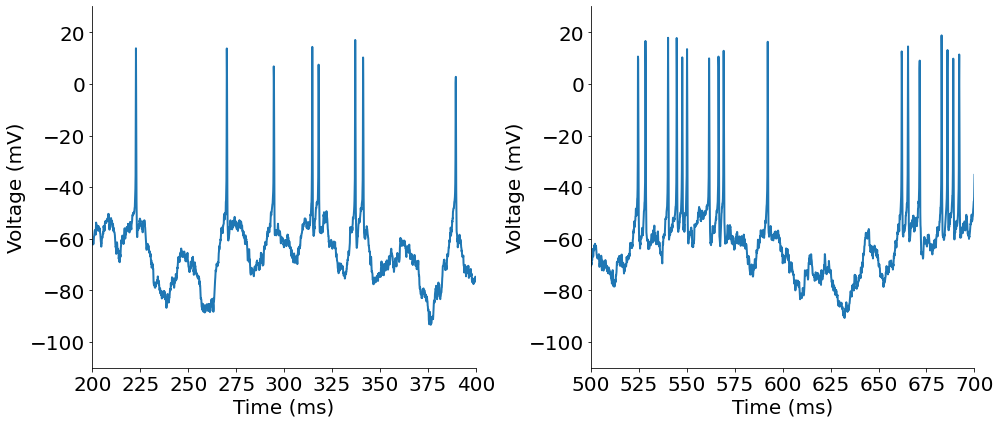

In [79]:
plt.figure(figsize=(14,6))
ax=plt.subplot(121)
plt.plot(t, x["data"], lw=2)
plt.xlim([200,400])
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(20)

ax=plt.subplot(122)
plt.plot(t, x["data"], lw=2)
plt.xlim([500,700])
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(20)  
plt.tight_layout()

plt.savefig(f"{images_dir}/ss_sb.png")
plt.savefig(f"{images_dir}/ss_sb.pdf")  

In [66]:
posterior_sample

array([[3.0135664e-01, 8.8550425e+00, 3.3956058e-02, 7.8534117e+00,
        8.4372856e-02, 1.0348655e+00, 5.4861560e+00, 2.2037923e+00,
        8.8473520e+00, 2.4756911e-01, 2.2713016e-01, 2.1942110e+00,
        6.1625280e+00, 8.0323571e-06, 6.2220740e+00, 8.9243889e+00,
        2.1687121e+00, 1.4793917e+00]], dtype=float32)

In [67]:
observation_summary_statistics

array([ 14.90549055,   1.56710264,   9.27452745,   1.17370591,
         5.6309631 ,   2.87596443, -56.95948182,  16.62823181,
       276.4980932 ,   0.72995675,   5.2118027 ,  12.28884896])

In [68]:
calculate_summary_statistics(x,t)

array([ 71.3       ,   1.36435384,   8.        ,   0.72719527,
        63.3       ,   1.71872721, -62.21047358,  13.84751488,
       191.75366826,   2.02222114,  11.74995516,  54.09442341])

In [70]:
#@title detecting SS/CS for each neuron but only first spike
SSNe = list([])
CSNe = list([])
dist = 14.0   #distance to distinguish ss/cs
Ne=1
for k in range(Ne):
  vs = x["data"]
  ids, _ = find_peaks(x["data"]>-20) #find the indices of spike
  """searching the CB"""
  sb = []
  for i in range(1,len(ids)):   #backward searching
    if t[ids[i]]-t[ids[i-1]]<dist:
      sb.append(ids[i])
  for i in range(len(ids)-1):   #foward searching
    if t[ids[i+1]]-t[ids[i]]<dist:
      sb.append(ids[i])
  sb = np.sort(sb)              #order
  sb = np.unique(sb)            #... and remove duplicate values   
  """find the SS"""
  ss = ids
  for i in sb:
    ind = np.where(ss == i)
    ss = np.delete(ss,ind)
  """save the SS and CS"""
  SSNe.append(ss)
  CSNe.append(sb)

"""save the first spike of burst"""
CSfs = list([])

for j in range(Ne):
  aux = list([])
  u = CSNe[0]
  aux.append(u[0])
  for k in range(1,len(u)):
    d = t[u[k]]-t[u[k-1]]
    if d>dist:
      aux.append(u[k])
  CSfs. append(aux)

In [71]:
#@title Average approach for PLV
from scipy import signal
fNQ = 1000 / dt / 2             # ... and Nyquist frequency. 
Frq = np.linspace(3,12,5) 
Bfil = list([])
for j in range(len(Frq)):
  f = Frq[j]
  Wn = [f-1,f+1];        # Set the passband in Hz,
  n=2000#22000             
  b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
  Bfil.append(b)


PLVss = np.zeros((Ne,len(Frq)))
PLSss = np.zeros((Ne,len(Frq)))

PLVcs = np.zeros((Ne,len(Frq)))
PLScs = np.zeros((Ne,len(Frq)))

for j in range(len(Frq)):
  b = Bfil[j]                         #select the filter
  for i in range(Ne):                 #select a single neuron to test
    vf = x["data"]#v_sav                        #...and take it averaged
    """detect the indices of spikes"""
    ss = SSNe[i]                        #take the indices of SS
    cs = CSfs[i]#CSNe[i]                        #...and indices of CS
    if len(cs)+len(ss)>1:               #check there are enough spikes
      """filtering"""
      Vfil = signal.filtfilt(b, 1, vf);  #butter_bandpass_filter(v4, j+1, j+5, 1/dt, order=10) #vf#  #apply the filter to the data. 
      phi = np.angle(signal.hilbert(Vfil)) 
      """PLV and PLS for SS"""
      if len(ss)>3:
        aux = 0
        for k in ss:
           aux = aux+np.exp(1j*phi[k])
        PLVss[i,j] = np.absolute(aux)/len(ss)
        PLSss[i,j] = (PLVss[i,j]**2*len(ss)-1)/(len(ss)-1)
      else:
        PLVss[i,j] = 'Nan'
        PLSss[i,j] = 'Nan'
      """PLV and PLS for SB"""
      if len(cs)>3:
        aux = 0
        for k in cs:
           aux = aux+np.exp(1j*phi[k])
        PLVcs[i,j] = np.absolute(aux)/len(cs)
        PLScs[i,j] = (PLVcs[i,j]**2*len(cs)-1)/(len(cs)-1)
      else:
        PLVcs[i,j] = 'Nan'
        PLScs[i,j] = 'Nan'

thPLSss = PLSss
thPLScs = PLScs

pls_ss_theta = np.mean(PLSss)
pls_cs_theta = np.mean(PLScs)

Frq = np.linspace(30,90,5) 
Bfil = list([])
for j in range(len(Frq)):
  f = Frq[j]
  Wn = [f-1,f+1];        # Set the passband in Hz,
  n=2000#5000             
  b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
  Bfil.append(b)


PLVss = np.zeros((Ne,len(Frq)))
PLSss = np.zeros((Ne,len(Frq)))

PLVcs = np.zeros((Ne,len(Frq)))
PLScs = np.zeros((Ne,len(Frq)))

for j in range(len(Frq)):
  b = Bfil[j]                         #select the filter
  for i in range(Ne):                 #select a single neuron to test
    vf = x["data"]                        #...and take it averaged
    """detect the indices of spikes"""
    ss = SSNe[i]                        #take the indices of SS
    cs = CSfs[i]#CSNe[i]                #...and indices of CS
    if len(cs)+len(ss)>1:               #check there are enough spikes
      """filtering"""
      Vfil = signal.filtfilt(b, 1, vf);  #butter_bandpass_filter(v4, j+1, j+5, 1/dt, order=10) #vf#  #apply the filter to the data. 
      phi = np.angle(signal.hilbert(Vfil)) 
      """PLV and PLS for SS"""
      if len(ss)>3:
        aux = 0
        for k in ss:
           aux = aux+np.exp(1j*phi[k])
        PLVss[i,j] = np.absolute(aux)/len(ss)
        PLSss[i,j] = (PLVss[i,j]**2*len(ss)-1)/(len(ss)-1)
      else:
        PLVss[i,j] = 'Nan'
        PLSss[i,j] = 'Nan'
      """PLV and PLS for SB"""
      if len(cs)>3:
        aux = 0
        for k in cs:
           aux = aux+np.exp(1j*phi[k])
        PLVcs[i,j] = np.absolute(aux)/len(cs)
        PLScs[i,j] = (PLVcs[i,j]**2*len(cs)-1)/(len(cs)-1)
      else:
        PLVcs[i,j] = 'Nan'
        PLScs[i,j] = 'Nan'

gmPLSss = PLSss
gmPLScs = PLScs

pls_ss_gamma = np.mean(PLSss)
pls_cs_gamma = np.mean(PLScs)


<ipython-input-71-847393d123f5>:10: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
<ipython-input-71-847393d123f5>:64: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');


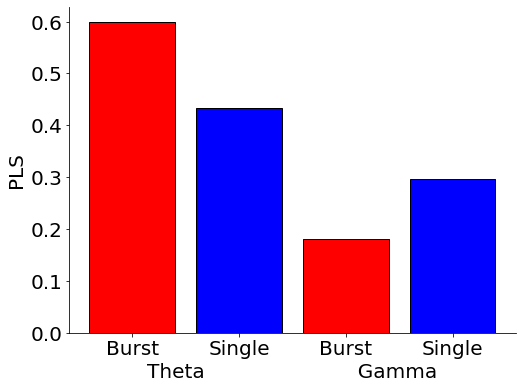

In [72]:
plt.figure(figsize=(8,6))
ax=plt.subplot(111)
bars = ('Burst', 'Single', 'Burst', 'Single')
plt.bar(x=np.arange(0,4),height=[pls_cs_theta, pls_ss_theta, pls_cs_gamma, pls_ss_gamma], color=['red', 'blue', 'red', 'blue'],edgecolor='black')
plt.xticks(np.arange(0,4), bars)
plt.xlabel('Theta                        Gamma')
plt.ylabel('PLS')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(20)

plt.savefig(f"{images_dir}/PLS_estim.png")
plt.savefig(f"{images_dir}/PLS_estim.pdf")  